# About
I learned a lot from Peter's kernal: [U-net, dropout, augmentation, stratification](https://www.kaggle.com/phoenigs/u-net-dropout-augmentation-stratification). 

I added more visualization to understand the analysis process.

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, './utils/')

from cyclelr_callback import *
from random import randint
from cyclelr_callback import *
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
from keras.layers.core import SpatialDropout2D, Activation

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization,UpSampling2D,Concatenate

from tqdm import tqdm_notebook
import datetime
from keras import backend as K


import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

/home/dex/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Params and helpers

In [2]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

# Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [3]:
train_df = pd.read_csv("./input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [4]:
train_df["images"] = [np.array(load_img("./input/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [5]:
train_df["masks"] = [np.array(load_img("./input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

# Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.
Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [6]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [7]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

# Show some example images

# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [8]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

In [9]:
INPUT_CHANNELS = 1
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1

def ZF_UNET_224(dropout_val=0.5, weights=None):
    if K.image_dim_ordering() == 'th':
        inputs = Input((INPUT_CHANNELS, img_size_target, img_size_target))
        axis = 1
    else:
        inputs = Input((img_size_target, img_size_target, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)

    model = Model(inputs, conv_final, name="ZF_UNET_224")

    if weights == 'generator' and axis == 3 and INPUT_CHANNELS == 3 and OUTPUT_MASK_CHANNELS == 1:
        weights_path = get_file(
            'zf_unet_224_weights_tf_dim_ordering_tf_generator.h5',
            ZF_UNET_224_WEIGHT_PATH,
            cache_subdir='models',
            file_hash='203146f209baf34ac0d793e1691f1ab7')
        model.load_weights(weights_path)

    return model
def double_conv_layer(x, size, dropout=0.0, batch_norm=True):
    if K.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

# Build model

In [10]:
model = ZF_UNET_224()

In [11]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

# Data augmentation

In [13]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

# Training

In [28]:
early_stopping = EarlyStopping(patience=10, verbose=1,monitor='val_acc', mode = 'max')
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1,monitor='val_acc', 
                                   mode = 'max')
clr_triangular = CyclicLR(mode='triangular2', base_lr=0.001, max_lr=0.006, step_size = 700) 

reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5, min_lr=0.00005, verbose=1)

epochs = 25
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, early_stopping])

Train on 6400 samples, validate on 800 samples
Epoch 1/25
6400/6400 [==============================] - 54s 8ms/step - loss: 0.2363 - acc: 0.9033 - val_loss: 0.4205 - val_acc: 0.8639

Epoch 00001: val_acc improved from -inf to 0.86392, saving model to ./keras.model
Epoch 2/25
6400/6400 [==============================] - 52s 8ms/step - loss: 0.2186 - acc: 0.9098 - val_loss: 0.3412 - val_acc: 0.8531

Epoch 00002: val_acc did not improve from 0.86392
Epoch 3/25
6400/6400 [==============================] - 51s 8ms/step - loss: 0.2114 - acc: 0.9138 - val_loss: 0.2233 - val_acc: 0.9142

Epoch 00003: val_acc improved from 0.86392 to 0.91415, saving model to ./keras.model
Epoch 4/25
6400/6400 [==============================] - 53s 8ms/step - loss: 0.1933 - acc: 0.9196 - val_loss: 0.2147 - val_acc: 0.9109

Epoch 00004: val_acc did not improve from 0.91415
Epoch 5/25
6400/6400 [==============================] - 53s 8ms/step - loss: 0.1899 - acc: 0.9208 - val_loss: 0.2031 - val_acc: 0.9193

Epoch 

In [ ]:
0.87553

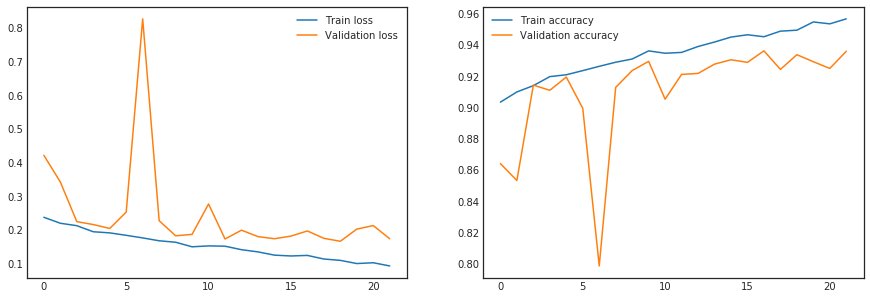

In [29]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.legend()

In [16]:
model = load_model("./keras.model")

# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [17]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
mask_valid = np.array([downsample(x) for x in y_valid])

# Scoring
Score the model and do a threshold optimization by the best IoU.

In [18]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [19]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(mask_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [20]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

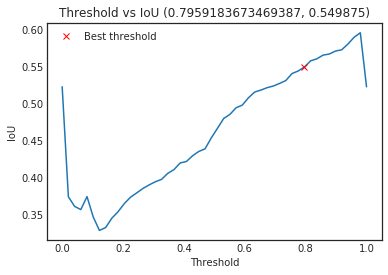

In [21]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Sanity check with adjusted threshold
Again some sample images with the adjusted threshold.

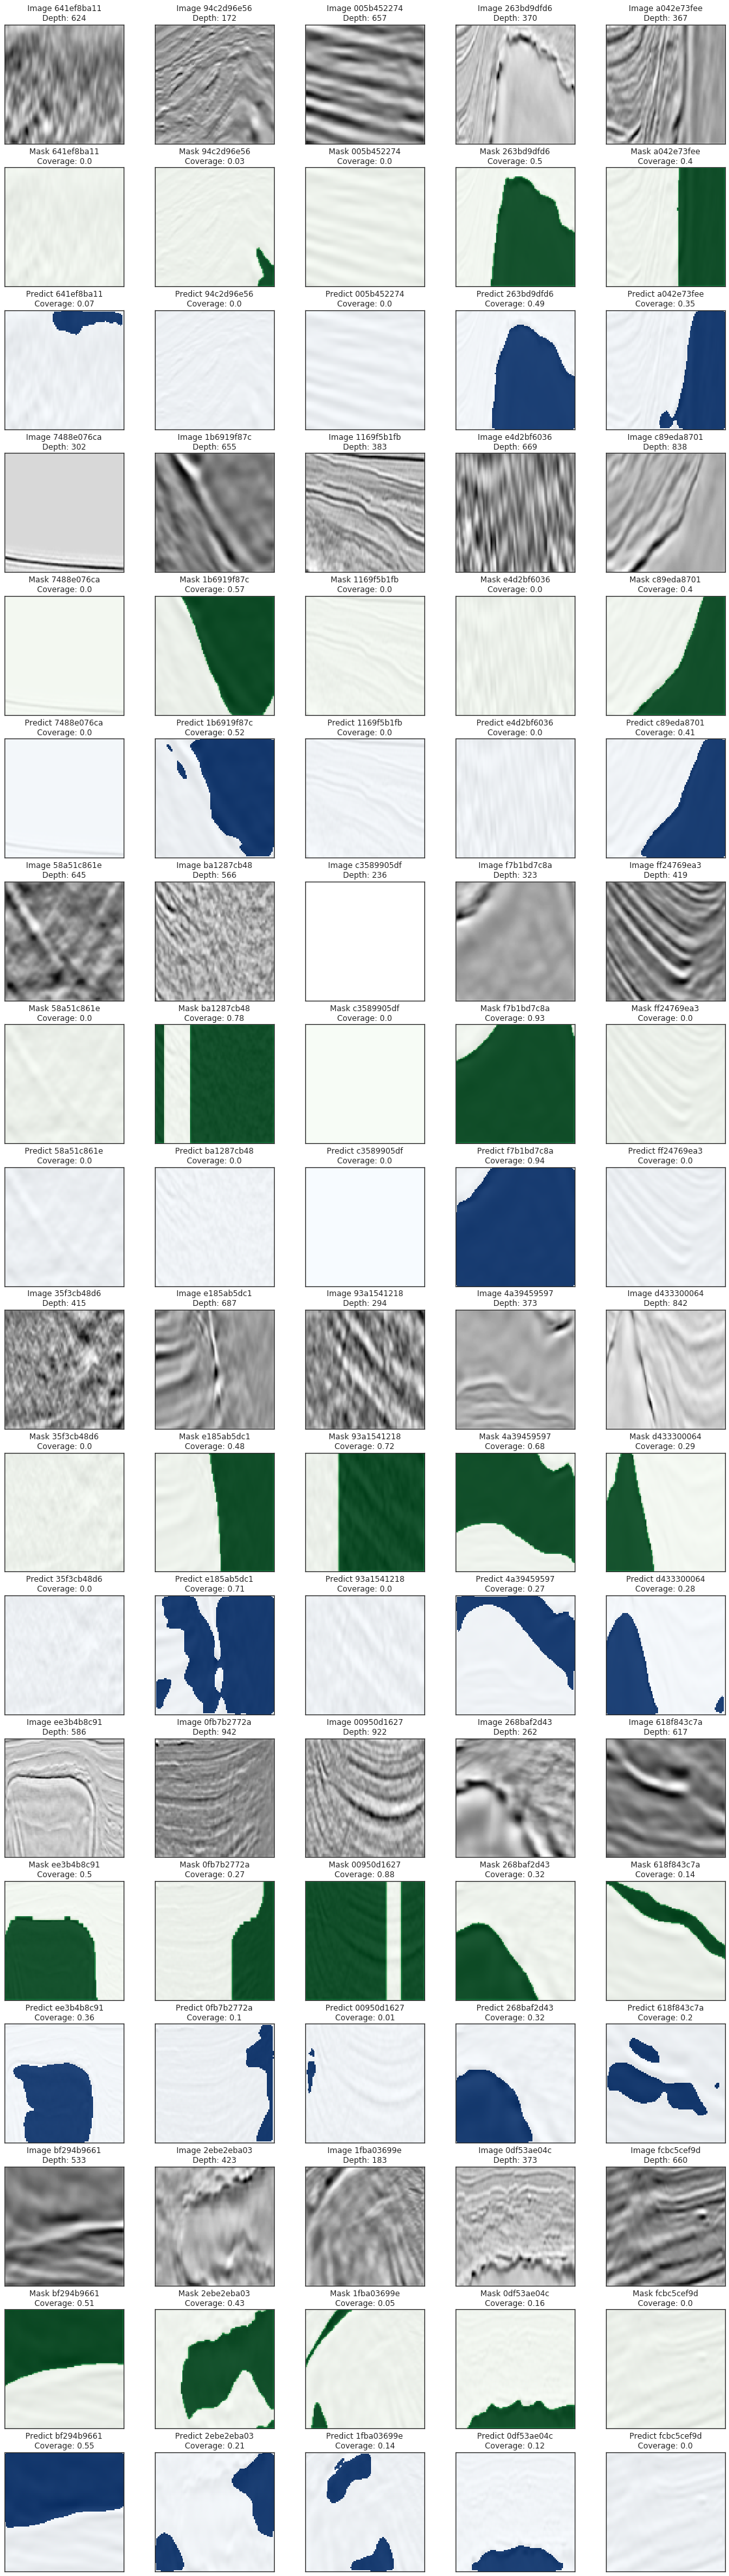

In [22]:
max_images = 30
grid_width = 5
grid_height = int(max_images / grid_width)*3
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
for i, idx in enumerate(ids_valid[:max_images]):
    #print(idx)
    img = downsample(np.squeeze(x_valid[i]))
    mask = np.squeeze(mask_valid[i])
    pred = np.squeeze(preds_valid[i]>threshold_best)
    ax_image = axs[int(i / grid_width)*3, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image {0}\nDepth: {1}".format(idx, train_df.loc[idx].z))
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*3+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.9, cmap="Greens")
    ax_mask.set_title("Mask {0}\nCoverage: {1}".format(idx,  round(train_df.loc[idx].coverage, 2)))
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])
    ax_pred = axs[int(i / grid_width)*3+2, i % grid_width]
    ax_pred.imshow(img, cmap="Greys")
    ax_pred.imshow(pred, alpha=0.9, cmap="Blues")
    coverage_pred = np.sum(pred) / pow(img_size_ori, 2)
    ax_pred.set_title("Predict {0}\nCoverage: {1}".format(idx,  round(coverage_pred, 2)))
    ax_pred.set_yticklabels([])
    ax_pred.set_xticklabels([])

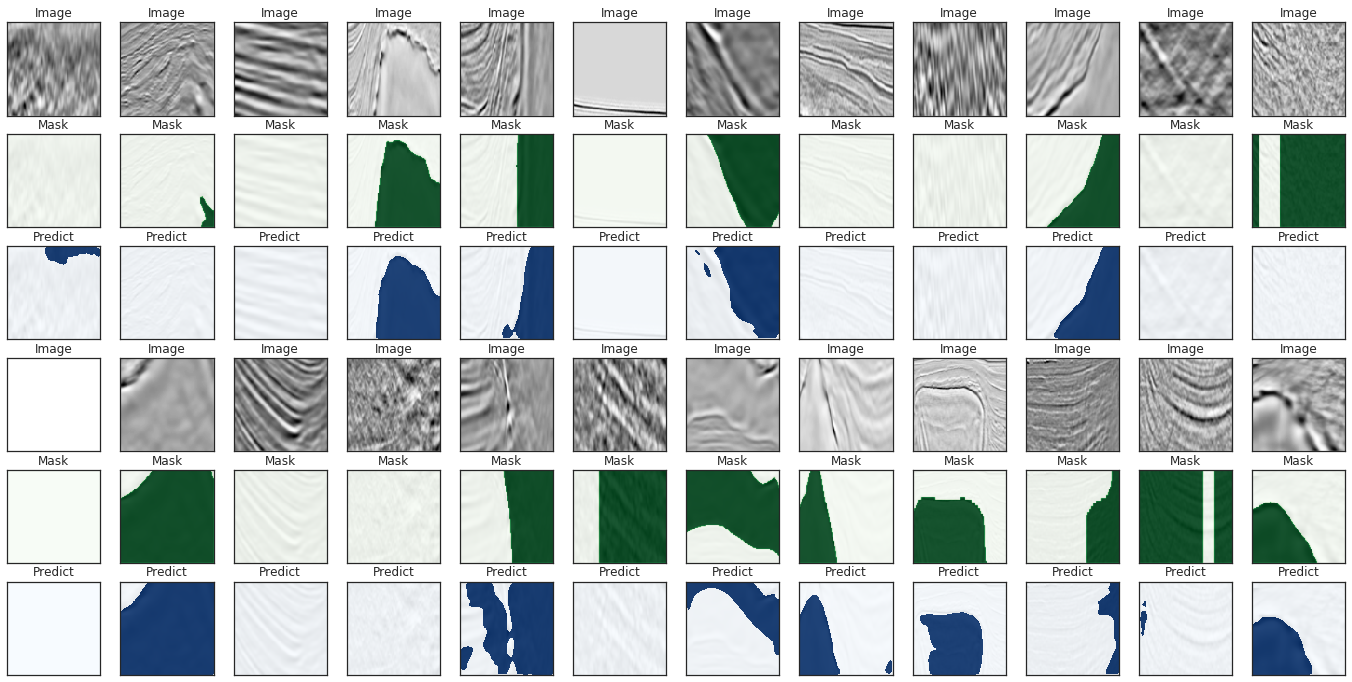

In [23]:
# plot small charts
max_images = 24
grid_width = 12
grid_height = int(max_images / grid_width)*3
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*2, grid_height*2))
for i, idx in enumerate(ids_valid[:max_images]):
    #print(idx)
    img = downsample(np.squeeze(x_valid[i]))
    mask = np.squeeze(mask_valid[i])
    pred = np.squeeze(preds_valid[i]>threshold_best)
    ax_image = axs[int(i / grid_width)*3, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image")
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*3+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.9, cmap="Greens")
    ax_mask.set_title("Mask")
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])
    ax_pred = axs[int(i / grid_width)*3+2, i % grid_width]
    ax_pred.imshow(img, cmap="Greys")
    ax_pred.imshow(pred, alpha=0.9, cmap="Blues")
    coverage_pred = np.sum(pred) / pow(img_size_ori, 2)
    ax_pred.set_title("Predict")
    ax_pred.set_yticklabels([])
    ax_pred.set_xticklabels([])

# Submission
Load, predict and submit the test image predictions.

In [24]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [25]:
x_test = np.array([upsample(np.array(load_img("./input/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [26]:
preds_test = model.predict(x_test)

In [27]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

KeyboardInterrupt: 

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
print('Submission output to: sub-{}.csv'.format(timestamp))
sub.to_csv("sub-{}.csv".format(timestamp))
